In [7]:
%load_ext autoreload
%autoreload 2
import sys
import os
import matplotlib.pyplot as plt
import torch
from visualizer import visualize_random_image, visualize_loss_acc_plot
from train import setup_train_args, build, test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
datasets = ["Kvasir", "CVC", "both"]
dataset = datasets[2]

In [9]:
args_train_student = setup_train_args(my_model="unet", temperature=4, alpha=0.9, dataset=dataset,
                                      data_root="./data_root/", batch_size=8, epochs=60, learning_rate=0.001)
from train import student_train_epoch

In [10]:
def train_student_with_teach(args):
    (device,
     train_dataloader,
     test_dataloader,
     val_dataloader,
     Dice_loss,
     BCE_loss,
     KLT_loss,
     perf,
     student_model,
     teach_model,
     optimizer,
     alpha,
     temperature) = build(args)

    loss_storage = []
    # performance metric is dice score
    perf_storage = []

    if not os.path.exists("./Trained_student_models/trained_with_teacher/"):
        os.makedirs("./Trained_student_models/trained_with_teacher/")

    model_name = student_model.__class__.__name__
    my_path = f"Trained_student_models/trained_with_teacher/{model_name}_temp_{temperature}_alpha_{alpha}_lr_{args_train_student.lr}" + args.dataset
    prev_best_test = None
    if args.lrs == "true":
        if args.lrs_min > 0:
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="max", factor=0.5, min_lr=args.lrs_min, verbose=True, patience=6
            )
        else:
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="max", factor=0.5, verbose=True, patience=6
            )
    for epoch in range(1, args.epochs + 1):
        try:
            loss = student_train_epoch(student_model, teach_model, device, train_dataloader,
                                       optimizer, epoch, Dice_loss, BCE_loss, KLT_loss, temperature, alpha)

            test_measure_mean, test_measure_std = test(
                student_model, device, val_dataloader, epoch, perf
            )
            # add means and loss for vis
            loss_storage.append(loss)
            perf_storage.append(test_measure_mean)

        except KeyboardInterrupt:
            print("Training interrupted by user")
            sys.exit(0)
        if args.lrs == "true":
            scheduler.step(test_measure_mean)
        # if prev_best_test == None or test_measure_mean > prev_best_test:
        #     print("Saving...")
        #     # torch.save(
        #     #     {
        #     #         "epoch": epoch,
        #     #         "model_state_dict": student_model.state_dict()
        #     #         if args.mgpu is False
        #     #         else student_model.module.state_dict(),
        #     #         "optimizer_state_dict": optimizer.state_dict(),
        #     #         "loss": loss,
        #     #         "test_measure_mean": test_measure_mean,
        #     #         "test_measure_std": test_measure_std,
        #     #     },
        #     #     my_path + ".pt",
        #     # )
        #     prev_best_test = test_measure_mean
        if epoch % 10 == 1: 
            visualize_random_image(test_dataloader, student_model)
    return loss_storage, perf_storage, my_path

Train Epoch: 1 [1288/1290 (100.0%)]	Average loss: 9.736685	Time: 26.054737
Test  Epoch: 1 [161/161 (100.0%)]	Average performance: 0.335598	Time: 1.190591


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


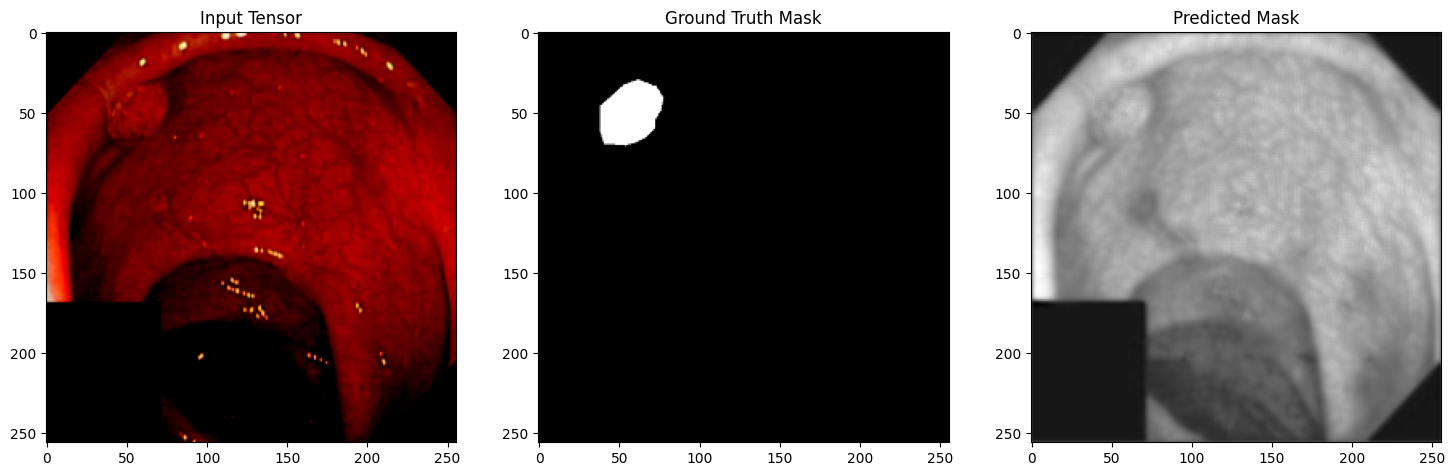

Train Epoch: 2 [1288/1290 (100.0%)]	Average loss: 9.509370	Time: 26.253912
Test  Epoch: 2 [161/161 (100.0%)]	Average performance: 0.305364	Time: 1.260257
Train Epoch: 3 [1288/1290 (100.0%)]	Average loss: 9.304163	Time: 26.162421
Test  Epoch: 3 [161/161 (100.0%)]	Average performance: 0.334991	Time: 1.211802
Train Epoch: 4 [1288/1290 (100.0%)]	Average loss: 9.108801	Time: 26.247307
Test  Epoch: 4 [161/161 (100.0%)]	Average performance: 0.335838	Time: 1.198814
Train Epoch: 5 [1288/1290 (100.0%)]	Average loss: 8.920687	Time: 26.524908
Test  Epoch: 5 [161/161 (100.0%)]	Average performance: 0.355708	Time: 1.185555
Train Epoch: 6 [1288/1290 (100.0%)]	Average loss: 8.673586	Time: 26.458432
Test  Epoch: 6 [161/161 (100.0%)]	Average performance: 0.391562	Time: 1.214225
Train Epoch: 7 [1288/1290 (100.0%)]	Average loss: 8.469193	Time: 26.403031
Test  Epoch: 7 [161/161 (100.0%)]	Average performance: 0.395197	Time: 1.205794
Train Epoch: 8 [1288/1290 (100.0%)]	Average loss: 8.297578	Time: 26.608345
T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


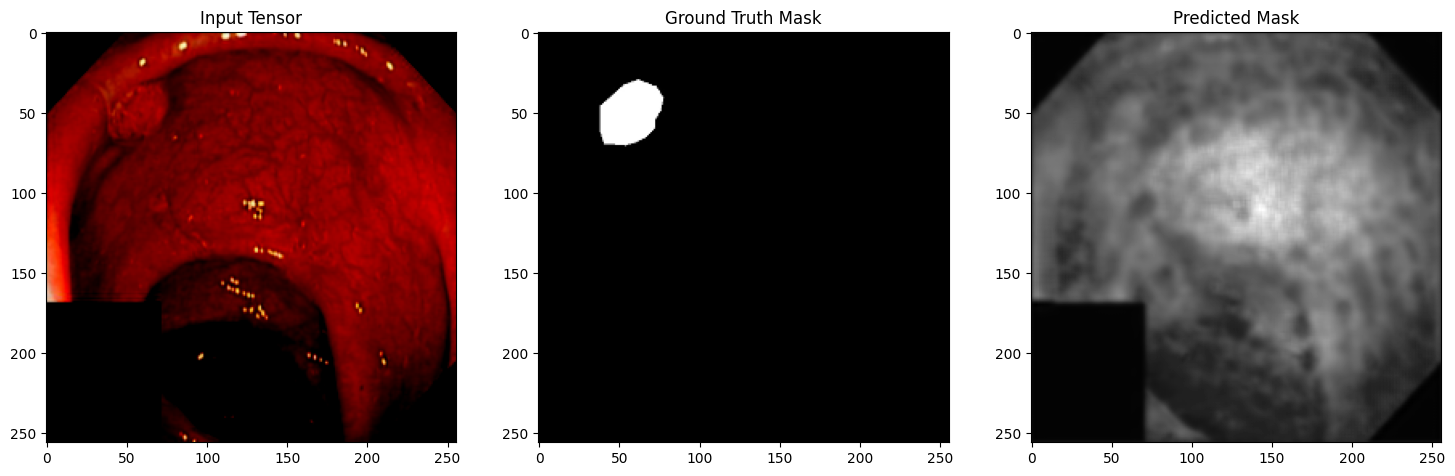

Train Epoch: 12 [1288/1290 (100.0%)]	Average loss: 7.643742	Time: 26.617474
Test  Epoch: 12 [161/161 (100.0%)]	Average performance: 0.450127	Time: 1.267490
Train Epoch: 13 [1288/1290 (100.0%)]	Average loss: 7.499505	Time: 26.945143
Test  Epoch: 13 [161/161 (100.0%)]	Average performance: 0.412289	Time: 1.181925
Train Epoch: 14 [1288/1290 (100.0%)]	Average loss: 7.354827	Time: 26.354883
Test  Epoch: 14 [161/161 (100.0%)]	Average performance: 0.444631	Time: 1.177072
Train Epoch: 15 [120/1290 (9.3%)]	Loss: 7.273996	Time: 3.989173Training interrupted by user


AttributeError: 'tuple' object has no attribute 'tb_frame'

In [11]:
losses, perfs, path = train_student_with_teach(args_train_student)

In [ ]:
visualize_loss_acc_plot(losses, acc_list=perfs, path=path+".png")